# Traffic Accidents in Brazillian Federal Highways

In [1]:
from sqlalchemy.exc import OperationalError, DatabaseError
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import mysql.connector as mysql
from dotenv import load_dotenv
import geopandas as gpd
import pandas as pd
import numpy as np
import logging
import os

# INTRO

## Setting up the working enviroment

*This was not where we started the project, but it should've been.*

This project was developed by Daniel Rocha and Vinicius Hedler, and so it was needed to set up a collaborative workspace. For this we used Github, by creating the repository in [github.com/viniciushedler/traffic-accidents-brazil](https://github.com/viniciushedler/traffic-accidents-brazil). Then, we kept on trying to install everything we need to run our scripts, but because of package conflicts we were having a really bad time, and after trying with some different virtual enviroments we chose virtualenv, and created one through the following windows cmd commands:

pip install virtualenv      *<-- install the virtualenv package*

virtualenv traffic_env      *<-- create the virtualenv*

traffic_env\Scripts\activate        *<-- activate the virtualenv*

pip install ipykernel       *<-- install the ipykernel in this virtualenv*

ipython kernel install --user --name=projectname        *<-- create a new ipykernel*

pip install pipwin      *<-- install the pipwin package,, destined to help windows users with installing packages through pip*

pipwin install package      *<-- installing the packages we wanted ('package' was actually the name of each package we needed)*

## Data collection
Our first step for the project was to collect the data we would be using. From the start we knew the data would be split into two: the geospacial data and the data that would be analyzed. The gathering of both is explained below:

### Data collection - traffic accidents
We started the project looking in Kaggle for data to analyze. Soon we found a database of traffic accidents in Brazil from the years of 2007 to 2021. Some of the columns that qualified this database were "uf" (which stands for "Unidade Federativa" - Brazil states), "municipio" (county), latitude, longitude and "data" (date), besides the base content of the database of course. So we downloaded the database from [here](https://www.kaggle.com/mcamera/brazil-highway-traffic-accidents). 

This big (2GB) database was added to our work enviroment, but was also added in the .gitignore file, so it would not be transfered to the online repository. How we made it available to application is mentioned further.

### Data collection - GeoJSon
Now we needed the GeoJson files to merge with our data and be able to analyze it in a geographical map. It was recomended by Renato Souze (our teacher), to use the files available in [this repository](https://github.com/tbrugz/geodata-br). However, we wanted to analyze the data for each state separetly and for all of them at once. 

In the first situation we could use the county shapes contained in the advised reposiroty, but in the second situation that would lead to ploting the data of thousands of countys all at once, which could lead to major performance issues, and so we decided to gather spacial data from other sources that contained the geometry of each state as one.

We found the data we wanted at 

## Data handling
We need to creates all the tables and populate them.

### Data storing
First, we connect to the database and create all tables in AWS RDS

In [2]:
def create_tables():
    """Create all tables: acidente, localidade, pessoa, veiculo, causa_acidente e tipo_acidente.
    """
    
    load_dotenv()
    db = mysql.connect(
        host = 'traffic-accidents.c1npf904zyic.sa-east-1.rds.amazonaws.com',
        user = os.getenv("db_user"),
        password = os.getenv("db_password"),
        database = 'sys',
        port = '3306')

    cursor = db.cursor()
    
    cursor.execute("""
                CREATE TABLE acidente (
                    id_acidente INT(10),
                    id_local INT(10),
                    id_pessoa INT(10),
                    id_veiculo INT(10),
                    id_causa INT(10),
                    id_tipo INT(10),
                    data DATE,
                    dia_semana VARCHAR(60),
                    horario TIME,
                    classificacao_acidente VARCHAR(60),
                    fase_dia VARCHAR(60),
                    sentido_via VARCHAR(60),
                    condicao_metereologica VARCHAR(60),
                    qtd_pessoas INT(10),
                    qtd_mortos INT(10),
                    qtd_feridos_leves INT(10),
                    qtd_feridos_graves INT(10),
                    qtd_ilesos INT(10),
                    qtd_ignorados INT(10),
                    qtd_feridos INT(10),
                    qtd_veiculos INT(10)
                    )""")

    cursor.execute("""
                CREATE TABLE localidade (
                    id_local INT(10),
                    latitude FLOAT(30, 30),
                    longitude FLOAT(30, 30),
                    uf VARCHAR(2),
                    municipio VARCHAR(60),
                    br INT(3),
                    km FLOAT(5, 5),
                    tipo_pista VARCHAR(60),
                    tracado_via VARCHAR(60),
                    uso_solo BOOLEAN,
                    regional VARCHAR(60),
                    delegacia VARCHAR(60),
                    uop VARCHAR(60)
                    )""")

    cursor.execute("""
                CREATE TABLE pessoa (
                    id_pessoa INT(10),
                    idade INT(10),
                    sexo VARCHAR(60),
                    nacionalidade VARCHAR(60),
                    naturalidade VARCHAR(60),
                    tipo_envolvido VARCHAR(60),
                    estado_fisico VARCHAR(60)
                    )""")

    cursor.execute("""
                CREATE TABLE veiculo (
                    id_veiculo INT(10),
                    id_pessoa INT(10),
                    tipo_veiculo VARCHAR(60),
                    marca VARCHAR(60),
                    ano_fabricacao_veiculo INT(4)
                    )""")

    cursor.execute("""
                CREATE TABLE causa_acidente (
                    id_causa INT(10),
                    id_pessoa INT(10),
                    causa_acidente VARCHAR(60),
                    causa_principal BOOLEAN
                    )""")

    cursor.execute("""
                CREATE TABLE tipo_acidente (
                    id_tipo INT(10),
                    id_pessoa INT(10),
                    tipo_acidente VARCHAR(60),
                    ordem_tipo_acidente INT(10)
                    )""")

### Data Grouping
Then, we group data from all the files and years

In [3]:
def group_data():
    """Group data from all the years available.
    """
    
    por_pessoa_todos_tipos = pd.concat(list(map(lambda x: pd.read_csv(f'data\\por_pessoa_todos tipos\\acidentes{x}_todas_causas_tipos.csv',
                                                    sep=';', encoding='latin-1'),
                            range(2017, 2022))), axis=0).replace('NA', pd.NA)

    por_pessoa = pd.concat(list(map(lambda x: pd.read_csv(f'data\\por_pessoa\\acidentes{x}.csv',
                                                    sep=';', encoding='latin-1'),
                            range(2007, 2022))), axis=0).replace('(null)', pd.NA).replace('NA', pd.NA)

    por_ocorrencia = pd.concat(list(map(lambda x: pd.read_csv(f'data\\por_ocorrencia\\datatran{x}.csv',
                                                    sep=';', encoding='latin-1', low_memory=False),
                            range(2007, 2022))), axis=0).replace('(null)', pd.NA)

    return por_pessoa_todos_tipos, por_pessoa, por_ocorrencia

### Data Cleaning
We restructure data and format data types

In [4]:
def restructure_data(por_pessoa_todos_tipos, por_pessoa, por_ocorrencia):
    """Select and rename columns and merge data.
    """
    
    por_ocorrencia = por_ocorrencia[['id', 'pessoas', 'mortos', 'feridos_leves', 'feridos_graves', 'ilesos', 'ignorados', 'feridos', 'veiculos']]
    por_ocorrencia = por_ocorrencia.rename(columns={'pessoas': 'qtd_pessoas', 'mortos': 'qtd_mortos', 'feridos_leves': 'qtd_feridos_leves',
                                                    'feridos_graves': 'qtd_feridos_graves', 'ilesos': 'qtd_ilesos', 'ignorados': 'qtd_ignorados',
                                                    'feridos': 'qtd_feridos', 'veiculos': 'qtd_veiculos'})

    por_pessoa = por_pessoa[['pesid', 'nacionalidade', 'naturalidade']]

    df = pd.merge(pd.merge(por_ocorrencia, por_pessoa_todos_tipos),
                pd.merge(por_pessoa.dropna(how='all'), por_pessoa_todos_tipos))

    df.rename(columns={'id': 'id_acidente', 'data_inversa': 'data', 'pesid': 'id_pessoa'}, inplace=True)

    df.drop(columns=['ilesos', 'feridos_graves', 'feridos_leves', 'mortos'], inplace=True)

    df = df.loc[df['tipo_veiculo'] != 'Não Informado']
    
    return df

In [5]:
def format_data(df):
    """Format data types to fit database formats.
    """
    
    df.data = pd.to_datetime(df.data)
    
    df.km = pd.to_numeric(df.km.str.replace(',', '.'))
    df.latitude = pd.to_numeric(df.latitude.str.replace(',', '.'))
    df.longitude = pd.to_numeric(df.longitude.str.replace(',', '.'))
    df.uso_solo = df.uso_solo.replace('Sim', True).replace('Não', False).replace('NÃ£o', False)
    df.causa_principal = df.causa_principal.replace('Sim', True).replace('Não', False).replace('NÃ£o', False)
    
    df.br = pd.to_numeric(df.br, downcast='integer')
    df.idade = pd.to_numeric(df.idade, downcast='integer')
    df.id_pessoa = pd.to_numeric(df.id_pessoa, downcast='integer')
    df.id_veiculo = pd.to_numeric(df.id_veiculo, downcast='integer')
    df.id_acidente = pd.to_numeric(df.id_acidente, downcast='integer')
    df.ordem_tipo_acidente = pd.to_numeric(df.ordem_tipo_acidente, downcast='integer')
    df.ano_fabricacao_veiculo = pd.to_numeric(df.ano_fabricacao_veiculo, downcast='integer')

    return df

### Populate database
Finally, we split the data in dataframes, connect to the database and populate the tables

In [6]:
def split_dataframes(df):
    """Split data in different dataframes to fit the database model.
    """
    
    localidade = df[['id_acidente', 'latitude', 'longitude', 'uf', 'municipio', 'br', 'km', 'tipo_pista', 'tracado_via', 'uso_solo', 'regional', 'delegacia', 'uop']].drop_duplicates()
    localidade.insert(0, 'id_local', range(1, len(localidade)+1))
    
    pessoa = df[['id_pessoa', 'idade', 'sexo', 'nacionalidade', 'naturalidade', 'tipo_envolvido', 'estado_fisico']].drop_duplicates()

    veiculo = df[['id_veiculo', 'id_pessoa', 'tipo_veiculo', 'marca', 'ano_fabricacao_veiculo']].drop_duplicates()
                                         
    causa_acidente = df[['id_pessoa', 'causa_acidente', 'causa_principal']].drop_duplicates()
    causa_acidente.insert(0, 'id_causa', range(1, len(causa_acidente)+1))
    
    tipo_acidente = df[['id_pessoa', 'tipo_acidente', 'ordem_tipo_acidente']].drop_duplicates()
    tipo_acidente.insert(0, 'id_tipo', range(1, len(tipo_acidente)+1))
    
    acidente = df[['id_acidente', 'id_pessoa', 'id_veiculo', 'data', 'dia_semana', 'horario', 'classificacao_acidente',
                   'fase_dia', 'sentido_via', 'condicao_metereologica', 'qtd_pessoas', 'qtd_mortos', 'qtd_feridos_leves',
                   'qtd_feridos_graves', 'qtd_ilesos', 'qtd_ignorados', 'qtd_feridos', 'qtd_veiculos']].drop_duplicates()
        
    acidente = pd.merge(pd.merge(pd.merge(localidade[['id_acidente', 'id_local']], acidente).drop_duplicates(),
                                 pd.merge(causa_acidente[['id_causa', 'id_pessoa']], acidente).drop_duplicates()).drop_duplicates(),
                        pd.merge(tipo_acidente[['id_tipo', 'id_pessoa']], acidente).drop_duplicates()).drop_duplicates()

    return acidente, localidade, pessoa, tipo_acidente, causa_acidente, veiculo

In [7]:
def connect_to_db(schema='sys', database='', return_df=True):
    """Query database and fetch table data.

    Args:
        schema (str): MySQL table schema. Default to 'sys'.
        database (str): MySQL table name. Deafult to ''.
        return_df (bool): Condition to return the dataframe.
    """
    
    load_dotenv()
    db_user = os.getenv("db_user")
    db_password = os.getenv("db_password")
    db_host = 'traffic-accidents.c1npf904zyic.sa-east-1.rds.amazonaws.com'
    db_port = '3306'
    
    params = f'{db_user}:{db_password}@{db_host}:{db_port}/{schema}'
    
    try:
        engine = create_engine("mysql+mysqlconnector://%s" % params, max_identifier_length=128, pool_size=1)
        engine.connect()
        Session = sessionmaker(bind=engine)
        session = Session()
    except Exception:
        logging.error("%s - Could not connect to database", database)

    if return_df == True:
        
        db_tb = pd.read_sql(f"SELECT * FROM {schema}.{database}", session.bind)

        return db_tb, engine, session

    else:
        
        return engine, session

In [8]:
def push_to_db(schema, database, dataframe):
    """Update database table with new data from 'diff'.

    Args:
        schema (str): MySQL table schema. Default to 'sys'.
        database (str): MySQL table name. Deafult to ''.
        dataframe (df): dataframe to be inserted in the database (e.g. acidente)
    """

    db_tb, engine, session = connect_to_db(schema, database)
    logging.info("%s - Connect to database", database)

    # Update the difference between recently acquired data and already available data
    diff = dataframe.merge(db_tb, how='outer', indicator=True).loc[lambda x:x['_merge'] == 'left_only'].drop(['_merge'], axis=1)

    if diff.shape[0] > 0:

        try:
            diff.to_sql(schema=schema, name=database, con=engine, chunksize=1000, index=False, if_exists='append')
            logging.info("%s - Push to Database - Success - New Data: %s rows", database, len(diff.index))
            session.commit()
        except (OperationalError, DatabaseError):
            logging.error("%s - Push to Database Fail", database)
            session.rollback()
    else:

        logging.info("%s - Nothing to update", database)

    engine.dispose()
    session.close()

In [9]:
def populate_tables(acidente, localidade, pessoa, tipo_acidente, causa_acidente, veiculo):
    """Insert data in all the tables, after cleaning it.
    """
    
    list(map(push_to_db, ['sys'] * 6,
             ['acidente', 'localidade', 'pessoa', 'tipo_acidente', 'causa_acidente', 'veiculo'],
             [acidente, localidade, pessoa, tipo_acidente, causa_acidente, veiculo]))

### Running the functions:

In [ ]:
create_tables()
por_pessoa_todos_tipos, por_pessoa, por_ocorrencia = group_data()
df = restructure_data(por_pessoa_todos_tipos, por_pessoa, por_ocorrencia)
df = format_data(df)
acidente, localidade, pessoa, tipo_acidente, causa_acidente, veiculo = split_dataframes(df)
populate_tables(acidente, localidade, pessoa, tipo_acidente, causa_acidente, veiculo)

# Analyzing the Data

Now, with the data prepared and saved where and how we need it, we can retrieve it and start analyzing it. 

## Retrieving Data
This is where we gather the data from wherever we saved it to our python scripts to further work with it. As we saved our traffic data and geospacial data separatedly, we also have to retrieve them separatedly and then combine them. Since we're using pandas, this means we are going to save them n dataframes and the merge.

### Retrieving traffic data
For the traffic data, what we need to do is to (again) connect to the database and then query what we want. Now the database serves it's purpose: if we were to simply save the data locally and fully load it, we would have those performance problems (because of the database's size). To avoid that, we send a query to the database and only retrieve what we are interested in at the moment.

This is done by connecting to the database and then using the session to make a query with pandas:

In [13]:
engine, session = connect_to_db(return_df=False)

acidentes_por_estado = pd.read_sql(f"""SELECT uf, COUNT(DISTINCT id_acidente) AS qtd_acidente, YEAR(data) as ano 
                                       FROM acidente 
                                       LEFT JOIN localidade ON acidente.id_local = localidade.id_local 
                                       WHERE YEAR(data) = 2020 
                                       GROUP BY uf
                                       """, session.bind)

vitimas_por_estado = pd.read_sql(f"""SELECT uf, COUNT(DISTINCT id_pessoa) AS qtd_vitimas, YEAR(data) as ano 
                                     FROM acidente 
                                     LEFT JOIN localidade ON acidente.id_local = localidade.id_local 
                                     WHERE YEAR(data) = 2020 
                                     GROUP BY uf""", session.bind)

obitos_por_estado = pd.read_sql(f"""SELECT uf, SUM(qtd_mortos) as qtd_mortos, YEAR(data) as ano 
                                    FROM acidente 
                                    LEFT JOIN localidade ON acidente.id_local = localidade.id_local 
                                    WHERE YEAR(data) = 2020 
                                    GROUP BY uf""", session.bind)

media_obitos_por_estado = pd.read_sql(f"""SELECT uf, AVG(qtd_mortos) as letalidade, YEAR(data) as ano 
                                          FROM acidente 
                                          LEFT JOIN localidade ON acidente.id_local = localidade.id_local 
                                          WHERE YEAR(data) = 2020 
                                          GROUP BY uf""", session.bind)

media_abs_obitos_por_estado = pd.read_sql(f"""SELECT uf, AVG(qtd_mortos) as letalidade, SUM(qtd_mortos) as qtd_mortos, YEAR(data) as ano 
                                              FROM acidente 
                                              LEFT JOIN localidade ON acidente.id_local = localidade.id_local 
                                              WHERE YEAR(data) = 2020 
                                              GROUP BY uf""", session.bind)

evolucao_acidentes_por_estado = pd.read_sql(f"""SELECT uf, COUNT(DISTINCT id_acidente) AS qtd_acidente, YEAR(data) as ano 
                                                FROM acidente 
                                                LEFT JOIN localidade ON acidente.id_local = localidade.id_local 
                                                GROUP BY uf, ano
                                                """, session.bind)

evolucao_vitimas_por_estado = pd.read_sql(f"""SELECT uf, COUNT(DISTINCT id_pessoa) AS qtd_vitimas, YEAR(data) as ano 
                                              FROM acidente 
                                              LEFT JOIN localidade ON acidente.id_local = localidade.id_local 
                                              GROUP BY uf, ano""", session.bind)

evolucao_obitos_por_estado = pd.read_sql(f"""SELECT uf, SUM(qtd_mortos) as qtd_mortos, YEAR(data) as ano 
                                             FROM acidente 
                                             LEFT JOIN localidade ON acidente.id_local = localidade.id_local 
                                             GROUP BY uf, ano""", session.bind)

evolucao_media_obitos_por_estado = pd.read_sql(f"""SELECT uf, AVG(qtd_mortos) as letalidade, YEAR(data) as ano 
                                                   FROM acidente 
                                                   LEFT JOIN localidade ON acidente.id_local = localidade.id_local 
                                                   GROUP BY uf, ano""", session.bind)

### Retrieving spacial data
For this one we use a library called GeoPandas, which is simply pandas with a new DataFrame type: GeoDataFrame, which can have columns that contain Polygons (or MultiPoligons) variables:

In [12]:
br_states = gpd.read_file("br_states_geo.json")

c:\Users\vinic\OneDrive\Área de Trabalho\FGV\Ciencia de dados\2021.2 - Segundo periodo\Banco de Dados\traffic-accidents-brazil\traffic_env\lib\site-packages\geopandas\array.py:85: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out


### Merging traffic and spatial data:
Now that we have all the data we needed, we can merge the dataframes to then analyze them. For that we merge the dataframes on the columns "uf" (from traffic) and "id" (from spatial), that contain the UF code of a state. We could do the same but with countys (and we actually do, just not here). The merge is inner, because we only want the occurencies of a given state (no None or similar in the "uf" column). Note that at the end we drop the column "id" because it is the same as column "uf", but with a *slightly* worse name.

In [14]:
def merge_geo_df(dataframe, geojson=br_states):
    
    return gpd.GeoDataFrame(dataframe.merge(right=geojson, left_on="uf", right_on="id", how="inner")).drop("id", axis=1)
   
geo_acidentes_por_estado = merge_geo_df(acidentes_por_estado)
geo_vitimas_por_estado = merge_geo_df(vitimas_por_estado)
geo_obitos_por_estado = merge_geo_df(obitos_por_estado)
geo_media_obitos_por_estado = merge_geo_df(media_obitos_por_estado)
geo_media_abs_obitos_por_estado = merge_geo_df(media_abs_obitos_por_estado)
geo_evolucao_acidentes_por_estado = merge_geo_df(evolucao_acidentes_por_estado)
geo_evolucao_vitimas_por_estado = merge_geo_df(evolucao_vitimas_por_estado)
geo_evolucao_obitos_por_estado = merge_geo_df(evolucao_obitos_por_estado)
geo_evolucao_media_obitos_por_estado = merge_geo_df(evolucao_media_obitos_por_estado)

## Ploting the data
Now that we have a suitable GeoDataFrame we can visualize it. To do so it's enough to use 'geodataframe.plot', which is a GeoPandas method that calls the matplotlib library to plot the data. The 'column' parameter defines which columns values are going to be analyzed.

In [15]:
def plot_geo_df(geo_dataframe, column_to_plot):
    geo_dataframe.plot(column=column_to_plot, legend=True)
    plt.axis('off')
    plt.show()

### Accidents by state
How many accidents happened in a determined state

c:\Users\vinic\OneDrive\Área de Trabalho\FGV\Ciencia de dados\2021.2 - Segundo periodo\Banco de Dados\traffic-accidents-brazil\traffic_env\lib\site-packages\geopandas\plotting.py:38: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
c:\Users\vinic\OneDrive\Área de Trabalho\FGV\Ciencia de dados\2021.2 - Segundo periodo\Banco de Dados\traffic-accidents-brazil\traffic_env\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


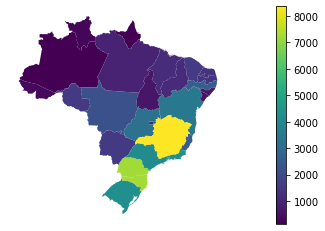

In [16]:
plot_geo_df(geo_acidentes_por_estado, 'qtd_acidente')

Here we can't really see a regional pattern besides from the one of population. However, that isn't as strong of a pattern, because Minas Gerais had more accidents than São Paulo, which has a lot more inhabitants. Two states that may be considered to have a lot of accidents are Paraná and Santa Catarina.

### Victims by state
How many people involved in accidents in a determined state

c:\Users\vinic\OneDrive\Área de Trabalho\FGV\Ciencia de dados\2021.2 - Segundo periodo\Banco de Dados\traffic-accidents-brazil\traffic_env\lib\site-packages\geopandas\plotting.py:38: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
c:\Users\vinic\OneDrive\Área de Trabalho\FGV\Ciencia de dados\2021.2 - Segundo periodo\Banco de Dados\traffic-accidents-brazil\traffic_env\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


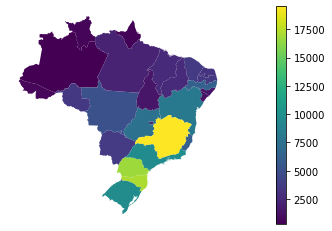

In [17]:
plot_geo_df(geo_vitimas_por_estado, 'qtd_vitimas')

This plot ended up not telling so much about the data, probably due to the average of victims per accident being quite homogeneuos through the states, as can be seen below:

In [30]:
vitimas_por_acidente = geo_vitimas_por_estado.merge(geo_acidentes_por_estado, on="uf")
vitimas_por_acidente["media_vitimas"] = geo_vitimas_por_estado["qtd_vitimas"]/geo_acidentes_por_estado["qtd_acidente"]
vitimas_por_acidente[["uf","media_vitimas"]].sort_values("media_vitimas", ascending=False)

,uf,media_vitimas
3,AP,2.538462
7,ES,2.388277
15,PE,2.384585
14,PB,2.366097
23,SC,2.362359
13,PA,2.352174
4,BA,2.339208
10,MG,2.335167
16,PI,2.332742
25,SP,2.331281


### Deceased by state
How many people died due to being involved in accidents

c:\Users\vinic\OneDrive\Área de Trabalho\FGV\Ciencia de dados\2021.2 - Segundo periodo\Banco de Dados\traffic-accidents-brazil\traffic_env\lib\site-packages\geopandas\plotting.py:38: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
c:\Users\vinic\OneDrive\Área de Trabalho\FGV\Ciencia de dados\2021.2 - Segundo periodo\Banco de Dados\traffic-accidents-brazil\traffic_env\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


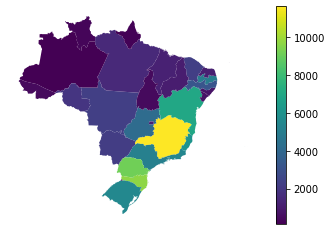

In [18]:
plot_geo_df(geo_obitos_por_estado, 'qtd_mortos')

This plot shows us how violent the accidents can be in some states. Bahia is the most expressive one, since it is a state with a medium amount of accidents but with a medium/high amount of deceased.

### Lethality by state
How many people die by accident, on average

c:\Users\vinic\OneDrive\Área de Trabalho\FGV\Ciencia de dados\2021.2 - Segundo periodo\Banco de Dados\traffic-accidents-brazil\traffic_env\lib\site-packages\geopandas\plotting.py:38: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
c:\Users\vinic\OneDrive\Área de Trabalho\FGV\Ciencia de dados\2021.2 - Segundo periodo\Banco de Dados\traffic-accidents-brazil\traffic_env\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


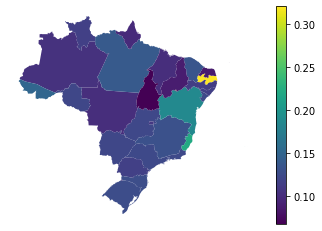

In [19]:
plot_geo_df(geo_media_obitos_por_estado, 'letalidade')

This is the most surprising plot, because there is a clear outlier: Paraíba. It is by far the state with the most killer accidents: with a rate of over 0.3 fatal victims per accident, whereas most of other states have a rate of 0.2 or less. This is how the plot looks without Paraíba:

c:\Users\vinic\OneDrive\Área de Trabalho\FGV\Ciencia de dados\2021.2 - Segundo periodo\Banco de Dados\traffic-accidents-brazil\traffic_env\lib\site-packages\geopandas\plotting.py:38: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
c:\Users\vinic\OneDrive\Área de Trabalho\FGV\Ciencia de dados\2021.2 - Segundo periodo\Banco de Dados\traffic-accidents-brazil\traffic_env\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


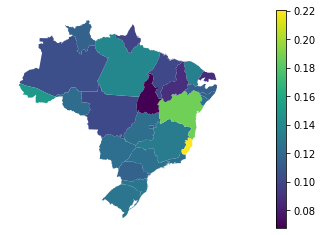

In [31]:
plot_geo_df(geo_media_obitos_por_estado[geo_media_obitos_por_estado["uf"]!="PB"], 'letalidade')

### Accidents by state by year
How the distribution of accidents has changed over the year through the brazillian states

In [20]:
def plot_evolution(geo_dataframe, column_to_plot):
    
    fig, axes = plt.subplots(figsize=(8, 8), ncols=2, nrows=2)
    for ano, x, y in zip(range(2017, 2021), [0, 0, 1, 1], [0, 1, 0, 1]):
        geo_dataframe.loc[lambda x: x['ano'] == ano].plot(ax=axes[x][y], column=column_to_plot, cmap='Reds')
        axes[x][y].axis('off')
        axes[x][y].set_title(ano)
    plt.show()       

c:\Users\vinic\OneDrive\Área de Trabalho\FGV\Ciencia de dados\2021.2 - Segundo periodo\Banco de Dados\traffic-accidents-brazil\traffic_env\lib\site-packages\geopandas\plotting.py:38: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
c:\Users\vinic\OneDrive\Área de Trabalho\FGV\Ciencia de dados\2021.2 - Segundo periodo\Banco de Dados\traffic-accidents-brazil\traffic_env\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
c:\Users\vinic\OneDrive\Área de Trabalho\FGV\Ciencia de dados\2021.2 - Segundo periodo\Banco de Dados\traffic-accidents-brazil\traffic_env\lib\site-packages\geopandas\plotting.py:38: ShapelyDeprecationWarning: Iteration over multi-part geometri

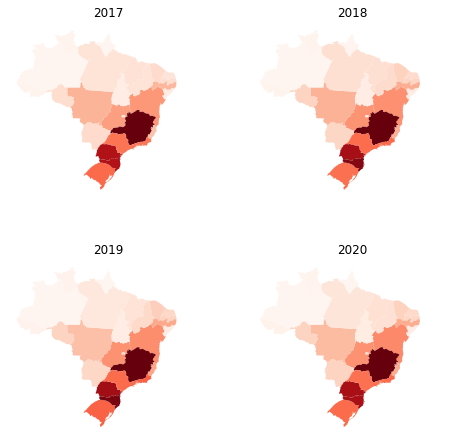

In [21]:
plot_evolution(geo_evolucao_acidentes_por_estado, 'qtd_acidente')        

The distribution of accidents throughout the country didn't change much, with Minas Gerais being the state with most accidents, followed by Santa Catarina and Paraná

### Deceased by state by year
How many people died due to being involved in a traffic accident by state and year

c:\Users\vinic\OneDrive\Área de Trabalho\FGV\Ciencia de dados\2021.2 - Segundo periodo\Banco de Dados\traffic-accidents-brazil\traffic_env\lib\site-packages\geopandas\plotting.py:38: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
c:\Users\vinic\OneDrive\Área de Trabalho\FGV\Ciencia de dados\2021.2 - Segundo periodo\Banco de Dados\traffic-accidents-brazil\traffic_env\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
c:\Users\vinic\OneDrive\Área de Trabalho\FGV\Ciencia de dados\2021.2 - Segundo periodo\Banco de Dados\traffic-accidents-brazil\traffic_env\lib\site-packages\geopandas\plotting.py:38: ShapelyDeprecationWarning: Iteration over multi-part geometri

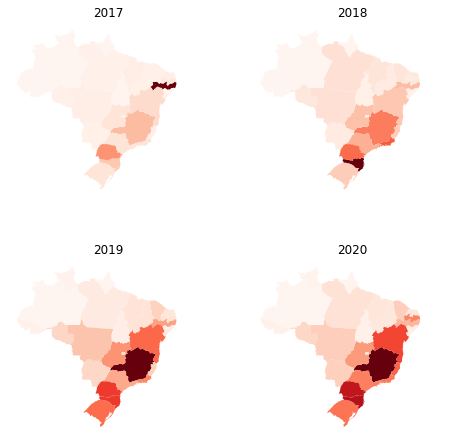

In [23]:
plot_evolution(geo_evolucao_obitos_por_estado, 'qtd_mortos')

Here we can see a change over the years. In 2017 Pernanbuco had the most deaths by far, and in the next years the tendency of Minas Gerais leading followed by Santa Catarina and Paraná came back. It's worth to mention the tendency of Bahia, which has been getting closer to the top as the years pass.

### How many people die per accident by state by year
How many people die per accident, on average, by state and year

c:\Users\vinic\OneDrive\Área de Trabalho\FGV\Ciencia de dados\2021.2 - Segundo periodo\Banco de Dados\traffic-accidents-brazil\traffic_env\lib\site-packages\geopandas\plotting.py:38: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
c:\Users\vinic\OneDrive\Área de Trabalho\FGV\Ciencia de dados\2021.2 - Segundo periodo\Banco de Dados\traffic-accidents-brazil\traffic_env\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
c:\Users\vinic\OneDrive\Área de Trabalho\FGV\Ciencia de dados\2021.2 - Segundo periodo\Banco de Dados\traffic-accidents-brazil\traffic_env\lib\site-packages\geopandas\plotting.py:38: ShapelyDeprecationWarning: Iteration over multi-part geometri

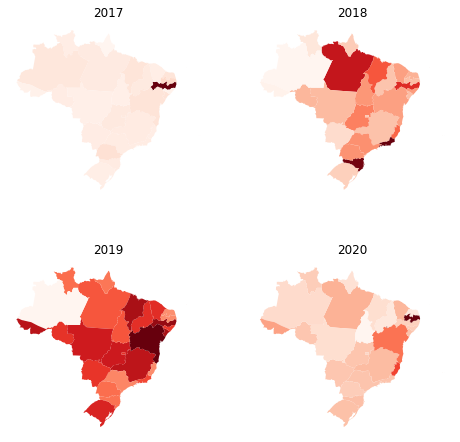

In [24]:
plot_evolution(geo_evolucao_media_obitos_por_estado, 'letalidade')  

As seen before, deaths in 2017 were concentrated in Pernambuco. However, in the nex year Pará was a highlight. If we go back to the other plots we can see that Pará is retatively low in terms of accidents, but higher in terms of general victims and even higher in terms of fatal victims, which confirms it's high fatalities per accident rate.
2019 was a well distributed year, with Santa Catarina and Espírito Santo, bot of which led the traffic deaths in the former year, getting lower in the charts, with Bahia being the deadliest. In 2020 we can see Paraíba's being the outlier.

## Deaths an Lethality by states
This plot was intended to show how many accidents happened in each state and the average of fatal victims per accident in the same state, in order to have an idea of how dangerous this state's traffic can be.

In [25]:
def plot_bubbles(geo_dataframe, column_to_size, column_to_color):
    
    centroids = geo_dataframe.copy()
    centroids.geometry = geo_dataframe.centroid
    centroids['size'] = centroids[column_to_size] / 15
    
    ax = geo_dataframe.plot(facecolor='w', edgecolor='k')

    labels, index = np.unique(geo_dataframe[column_to_color], return_inverse=True)

    centroids.plot(markersize='size', edgecolor='black', linewidth=1, c=index, ax=ax, cmap='Reds')
    
    plt.axis('off')
    plt.show()

c:\Users\vinic\OneDrive\Área de Trabalho\FGV\Ciencia de dados\2021.2 - Segundo periodo\Banco de Dados\traffic-accidents-brazil\traffic_env\lib\site-packages\geopandas\array.py:524: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return _unary_geo("centroid", self)
c:\Users\vinic\OneDrive\Área de Trabalho\FGV\Ciencia de dados\2021.2 - Segundo periodo\Banco de Dados\traffic-accidents-brazil\traffic_env\lib\site-packages\geopandas\geoseries.py:133: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = from_shapely(s.values)
c:\Users\vinic\OneDrive\Área de Trabalho\FGV\Ciencia de dados\2021.2 - Segundo periodo\Banco de Dados\traffic-accidents-brazil\traffic_env\lib\site-packages\geopandas\plotting.py:38: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and w

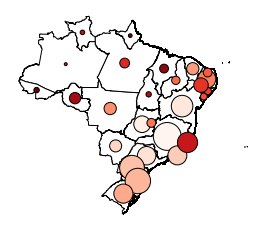

In [26]:
plot_bubbles(geo_media_abs_obitos_por_estado, 'qtd_mortos', 'letalidade')

We can see that some of the states with the highest number of accidents are also the leaast deadly, and vice versa. However, there are some states that have both and elevated accident count and lethality rate, such as Santa Catarina, Paraná and Espírito Santo, which should then be avoided by those who dread traffic violence.